# Определение стоимости автомобилей

**Описание проекта**

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля. 

Необходимо построить модель, которая умеет её определять. В распоряжении есть данные о технических характеристиках, комплектации и ценах других автомобилей.

Критерии, которые важны заказчику:
- качество предсказания;
- время обучения модели;
- время предсказания модели.


**Основные шаги:**

- загрузка данных;
- изучение данных. Заполннение пропущенныех значений и обработка аномалий в столбцах; 
- подготовка выборки для обучения моделей;
- обучение разных моделей, одна из которых — LightGBM, как минимум одна — не бустинг, для каждой модели будет спользован перебор гиперпараметров;
- анализ времени обучения, времени предсказания и качества моделей;
- выбор лучшей модели, согласно критериям заказчика.

Примечания:

Для оценки качества моделей будет использована метрика RMSE.

**Значение метрики RMSE должно быть меньше 2500.**
 
**Описание данных**

*Признаки*

- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `Repaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя

*Целевой признак*

- `Price` — цена (евро)

## Подготовка данных

**Импорт необходимых для работы библиотек.**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

pd.set_option('display.max_columns', None)

from colorama import Fore, Style 

import warnings

warnings.filterwarnings('ignore')

RANDOM = 1234

**Загрузка датасета.**

In [2]:
try:
    data = pd.read_csv("/datasets/autos.csv")
except FileNotFoundError:
    data = pd.read_csv("https://code.s3.yandex.net/datasets/autos.csv")

**Первые пять строк датасета.**

In [3]:
print(
    f"{Fore.GREEN}{Style.BRIGHT}Первые пять строк датасета:{Style.RESET_ALL}")
display(data.head())

Первые пять строк датасета:


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Имена столбцов приведены в произвольной форме. Приведем их к змеиному стилю.

In [4]:
data.columns = data.columns.str.replace(r"([A-Z])",
                                        r"_\1").str.strip('_').str.lower()

**Вывод информации по датафрейму и пропусков в данных**

In [5]:
print(
    f"{Fore.GREEN}{Style.BRIGHT}Информация по датафрейму:{Style.RESET_ALL} \n")
data.info()

Информация по датафрейму: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354

In [6]:
print(f"{Fore.RED}{Style.BRIGHT}Пропуски в данных:{Style.RESET_ALL}")
display(data.isna().sum())

Пропуски в данных:


date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
repaired              71154
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

**Описательная статистика**

In [7]:
display(data.describe().T)

,count,mean,std,min,25%,50%,75%,max
price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
registration_year,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
registration_month,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
number_of_pictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
postal_code,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0


Из выше приведенной статистики видно: 
- есть пропуски в данных (столбцы: `vehicle_type`, `gearbox`, `model`, `fuel_type`, `repaired`); 
- можно заменить типы данных в столбцах;
- в целевом признаке `price` есть нулевая цена;
- в столбце `registration_year` есть странные значения вроде 1000 или 9999 годов;
- в столбце `registration_month` есть нулевой месяц;
- фотографии машин `number_of_pictures` вообще отсутствуют.

Столбец с фотографиями `number_of_pictures` можно удалить сразу как абсолютно неинформативный для дальнейшего исследования.

In [8]:
data = data.drop(['number_of_pictures'], axis=1)

**Проверка на дубликаты.**

In [9]:
data.duplicated().sum()

4

Удаление дубликатов

In [10]:
data.drop_duplicates(inplace=True)

**Обработка пропусков.**

**Столбец `model` - модель автомобиля** 

В столбце 19705 пропусков. Это 5% от всей выборки. Но модель существенный параметр для формирования цены. Т.к. фотографии отсутствуют и не возможно понять что это за машина - пропуски лучше удалить.

In [11]:
data.dropna(subset=['model'], inplace=True)

**Столбец `repaired` — была машина в ремонте или нет**

Есть два значения `yes` и `no`. Пропусков 71154 - это 20% от выборки. Процент большой.
Любая машина скорее всего будет в ремонте. Но существует вероятность, что машина проходила только ТО и действительно не была в незапланированном ремонте..

Поэтому можно заменить пропуски на значение `unknown`, чтобы не терять 20% выборки

In [12]:
data.fillna({'repaired': 'unknown'}, inplace=True)

**Столбец `fuel_type` — тип топлива**

In [13]:
data['fuel_type'].sort_values().unique()

array(['cng', 'electric', 'gasoline', 'hybrid', 'lpg', 'other', 'petrol',
       nan], dtype=object)

Имеется 32895 пропусков - это около 9% выборки. В уникальных значениях есть тип `other`. Чтобы не придумывать новое значение и сохранить выборку, заполним пропуски этим значением. 

In [14]:
data.fillna({'fuel_type': 'other'}, inplace=True)

**Столбец `gearbox` — тип коробки передач**

In [15]:
data['gearbox'].sort_values().unique()

array(['auto', 'manual', nan], dtype=object)

Имеется 19833 пропусков - это около 5% выборки. В уникальных значениях два значения ручная или автомат. Параметр для формирования цены существенный. заменим пропуски на `manual`

In [16]:
data.fillna({'gearbox': 'manual'}, inplace=True)

**Столбец `vehicle_type` - тип автомобильного кузова**

In [17]:
data['vehicle_type'].sort_values().unique()

array(['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv',
       'wagon', nan], dtype=object)

In [18]:
data.loc[data['vehicle_type'].isna(),
         ['vehicle_type', 'model', 'brand']].head()

,vehicle_type,model,brand
0,NaN,golf,volkswagen
16,NaN,polo,volkswagen
22,NaN,meriva,opel
26,NaN,c4,citroen
31,NaN,clio,renault


In [19]:
data.loc[data['vehicle_type'] == 'other',
         ['vehicle_type', 'model', 'brand']].head()

,vehicle_type,model,brand
36,other,kadett,opel
38,other,other,volkswagen
76,other,vito,mercedes_benz
191,other,golf,volkswagen
433,other,other,citroen


In [20]:
data.loc[data['model'] == 'accord', 'vehicle_type'].sort_values().unique()

array(['coupe', 'sedan', 'small', 'wagon', nan], dtype=object)

In [21]:
data.loc[data['model'] == 'golf', 'vehicle_type'].sort_values().unique()

array(['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv',
       'wagon', nan], dtype=object)

Выше видно, что заполнение данных было сделано совсем странным образом. К примеру для VW Golf есть мнго типов кузова: `['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv', 'wagon', nan]`, а это вообще хэтчбэк...

По Honda Accord все более или менее правильно. Поэтому заменим пропуски на `unknown`

In [22]:
data.fillna({'vehicle_type': 'unknown'}, inplace=True)

**Обработка аномальных значений.**

In [23]:
#функции для вывода гистограммы и диаграммы размаха

def histogram(column):
    plt.figure(figsize=(15, 10))
    plt.title('Гистограмма')
    sns.histplot(data=data, x=column, kde=True)
    plt.show()
    
def box(column):
    plt.figure(figsize=(10, 5))
    plt.title('Диаграмма размаха')
    sns.boxplot(x=column, color='g', data=data, orient='h', fliersize=6)
    plt.show()

**Столбец `price`**

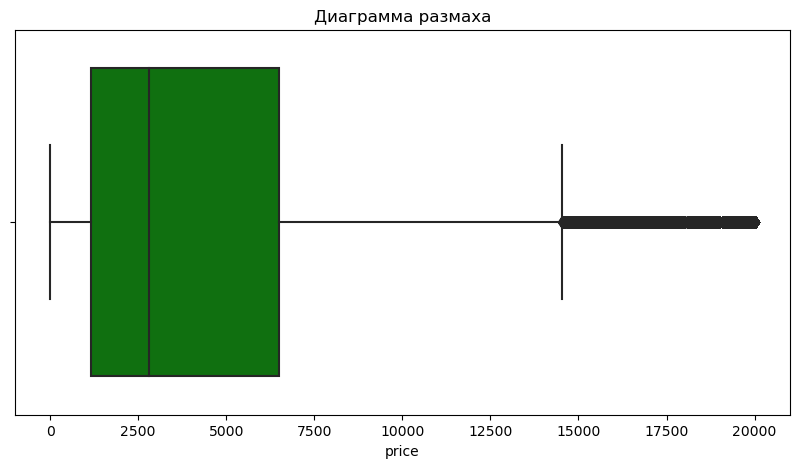

In [24]:
box('price')

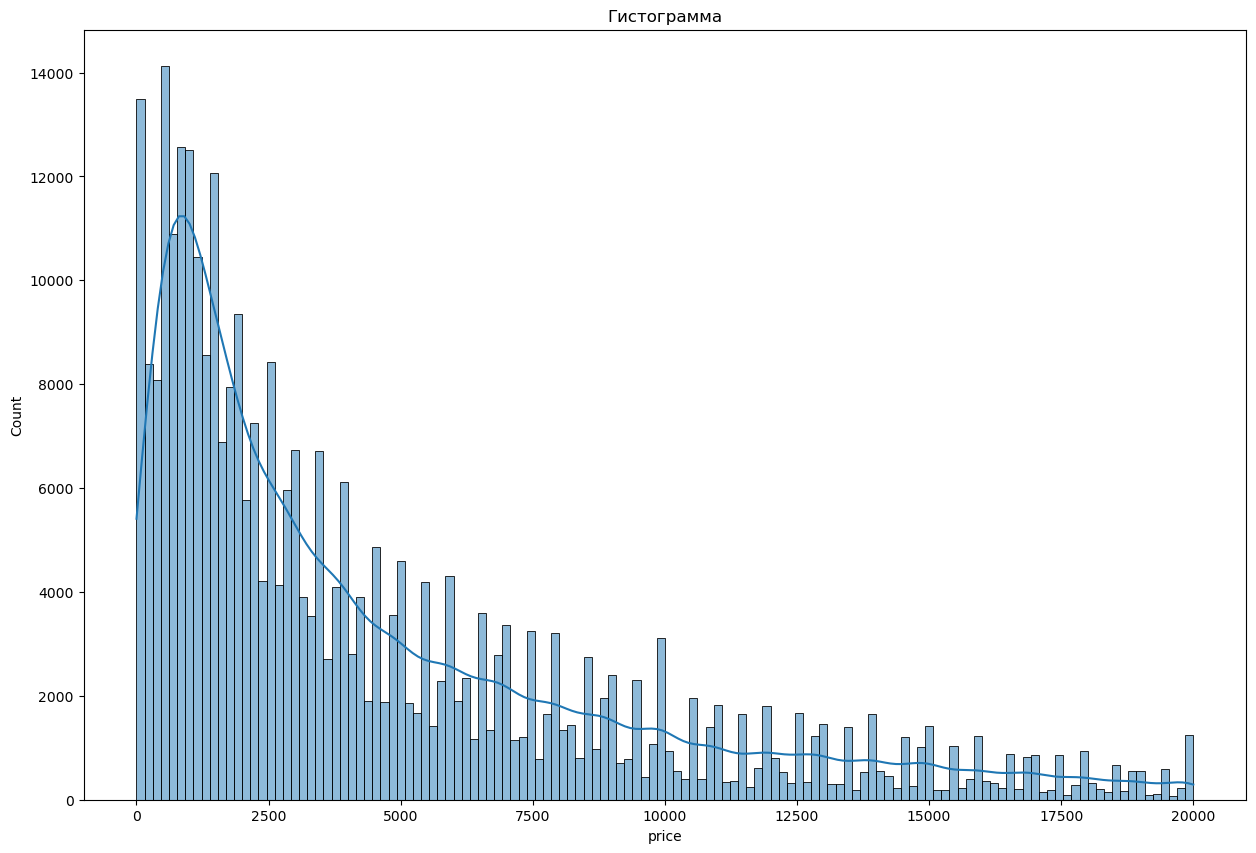

In [25]:
histogram('price')

In [26]:
data['price'].describe()

count    334660.000000
mean       4504.372249
std        4531.457109
min           0.000000
25%        1150.000000
50%        2800.000000
75%        6500.000000
max       20000.000000
Name: price, dtype: float64

Присутствуют нулевые значения цены. Строки с нулем лучше удалить. 25% квантиль это цена 1150 евро. за машину.
В принципе подержанные машины могут стоить меньше. Проверим 10%-квантиль.

In [27]:
data['price'].quantile([.1])

0.1    500.0
Name: price, dtype: float64

В принципе машину за 500 евро. даже могут быть на ходу. На нашем auto.ru такие иногда бывают)). Поэтому оставляем все, что дороже 500 евро. Максимум в 20000 евро вполне реален.

In [28]:
data = data.loc[data['price'] >= 500]

**Столбец `registration_year`**

In [29]:
data['registration_year'].describe()

count    303630.000000
mean       2004.014116
std          53.271307
min        1000.000000
25%        2000.000000
50%        2004.000000
75%        2008.000000
max        9999.000000
Name: registration_year, dtype: float64

In [30]:
data['registration_year'].sort_values().unique()

array([1000, 1001, 1400, 1500, 1600, 1602, 1800, 1910, 1923, 1927, 1928,
       1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1941,
       1942, 1943, 1945, 1947, 1949, 1950, 1951, 1952, 1953, 1954, 1955,
       1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966,
       1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977,
       1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988,
       1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999,
       2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2066, 2290,
       2900, 3700, 4000, 4500, 5000, 5555, 5911, 6000, 7000, 7100, 7800,
       8200, 8500, 9000, 9999])

Видно, что есть аномальные значения ранее 1910 года и позже 2019 года. Эти значения будут отброшены.

Помимо этого есть столбец `date_created` - дата создания анкеты. 

In [31]:
data['date_created'].max()

'2016-04-07 00:00:00'

Максимум тут 7 апреля 2016 года. Соотсветственно годы регистрации позденее 2016 года и совсем старые машины старше 50 лет можно отбросить.  

In [32]:
data = data.loc[(data['registration_year'] >= 1965)
                & (data['registration_year'] <= 2016)]

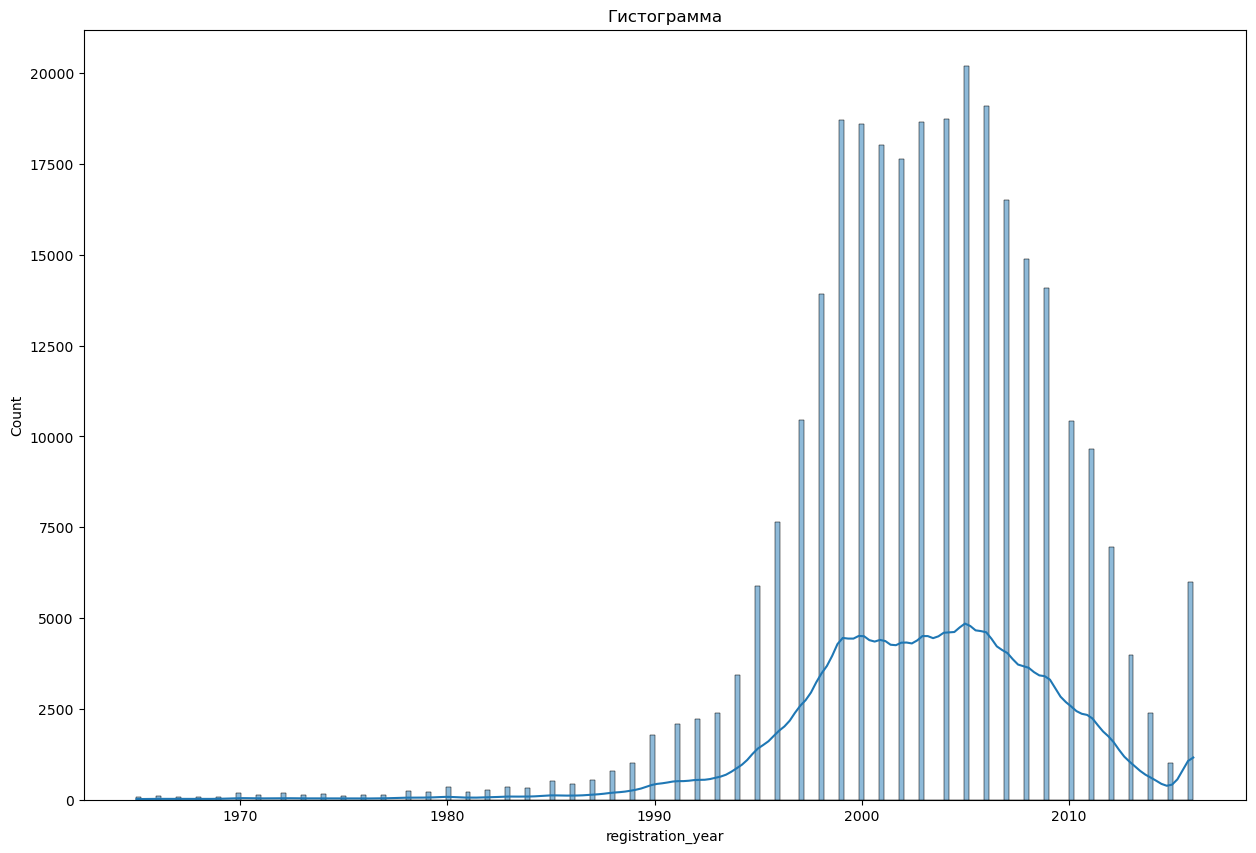

In [33]:
histogram('registration_year')

**Столбец `power` — мощность (л. с.)**

In [34]:
data['power'].describe()

count    291995.000000
mean        116.724276
std         182.436241
min           0.000000
25%          75.000000
50%         109.000000
75%         147.000000
max       20000.000000
Name: power, dtype: float64

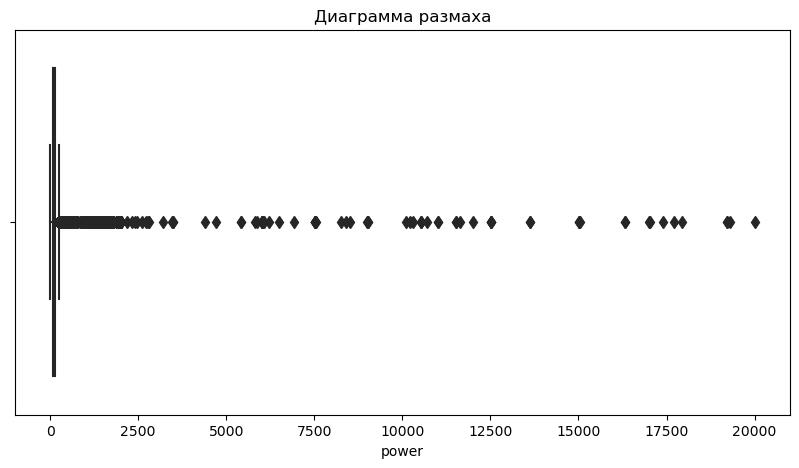

In [35]:
box('power')

In [36]:
data.loc[data['power'] >= 600]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,postal_code,last_seen
1816,2016-03-22 20:52:00,3200,small,2004,manual,1398,corolla,5000,6,petrol,toyota,no,2016-03-22 00:00:00,22043,2016-03-22 21:43:26
4060,2016-04-03 20:31:00,3100,sedan,2005,manual,953,colt,150000,4,gasoline,mitsubishi,no,2016-04-03 00:00:00,60326,2016-04-07 14:56:46
5328,2016-03-29 19:44:48,500,wagon,1999,manual,1001,astra,150000,7,petrol,opel,unknown,2016-03-29 00:00:00,33154,2016-04-06 05:44:36
6296,2016-03-31 23:50:47,599,small,2002,manual,603,matiz,5000,11,petrol,chevrolet,yes,2016-03-31 00:00:00,44379,2016-04-01 03:41:52
6504,2016-03-14 15:54:34,3000,small,2009,manual,771,punto,125000,0,petrol,fiat,unknown,2016-03-14 00:00:00,40721,2016-03-14 15:54:34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348237,2016-04-04 12:38:11,3000,coupe,2007,manual,2007,corsa,150000,3,gasoline,opel,yes,2016-04-04 00:00:00,72218,2016-04-04 12:38:11
348668,2016-03-05 17:53:09,1000,wagon,1996,manual,2598,a6,150000,7,other,audi,unknown,2016-03-05 00:00:00,7646,2016-03-07 16:17:01
348883,2016-03-13 11:51:57,7500,sedan,2011,manual,1548,scenic,90000,4,petrol,renault,unknown,2016-03-13 00:00:00,24568,2016-04-06 15:17:39
351947,2016-03-07 21:36:19,1500,bus,2001,manual,1001,zafira,5000,7,gasoline,opel,no,2016-03-07 00:00:00,66117,2016-03-09 12:47:08


Выше видно, что данные заполнялись вообще не понятным образом. Ограничим верхний порог как 600 л.с. и нижний как 10 л.с 

In [37]:
data = data.loc[(data['power'] >= 10) & (data['power'] <= 600)]

**Столбец `kilometer` — пробег (км)**

In [38]:
data['kilometer'].describe()

count    269428.000000
mean     127748.749202
std       36766.776612
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64

Тут все в норме. Оставляем как есть.

**Столбец `registration_month` — пробег (км)**

В столбце есть нулевые значения. Возможно это ошибка и это 10 месяц. Чтобы не терять часть выборки заменим на 10 месяц. 

In [39]:
data.loc[data['registration_month'] == 0, 'registration_month'] = 10

**Столбец `postal_code` — почтовый индекс владельца анкеты**

В дальнейшем столбец не понадобится, т.к. данные и синдексом владельца на цену не влияют. Его можно удалить.
Так же можно удалить столбцы: `date_crawled`, `date_created`, `last_seen`

In [40]:
data = data.drop(['date_crawled', 'date_created', 'postal_code', 'last_seen'],
                 axis=1)

**Приведение типов данных к оптимальным.**

In [41]:
data['registration_month'] = data['registration_month'].astype('uint8')
data[['price', 'power',
      'registration_year']] = data[['price', 'power',
                                    'registration_year']].astype('uint16')
data['kilometer'] = data['kilometer'].astype('uint32')

In [42]:
print(
    f"{Fore.GREEN}{Style.BRIGHT}Финальная информация по датафрейму:{Style.RESET_ALL} \n"
)
data.info()

Финальная информация по датафрейму: 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 269428 entries, 2 to 354368
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               269428 non-null  uint16
 1   vehicle_type        269428 non-null  object
 2   registration_year   269428 non-null  uint16
 3   gearbox             269428 non-null  object
 4   power               269428 non-null  uint16
 5   model               269428 non-null  object
 6   kilometer           269428 non-null  uint32
 7   registration_month  269428 non-null  uint8 
 8   fuel_type           269428 non-null  object
 9   brand               269428 non-null  object
 10  repaired            269428 non-null  object
dtypes: object(6), uint16(3), uint32(1), uint8(1)
memory usage: 17.2+ MB


**Данные подготовлены.**

## Обучение моделей

**Выделение целевого признака и признаков для обучения.**

In [43]:
target = data['price']
features = data.drop(['price'], axis=1)

**Разбиение на тренировочную и тестовую выборки в соотношении 80% на 20%.**

In [44]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=.2, random_state=RANDOM)

**Проверка разбиения на выборки.**

In [45]:
features_train.shape, target_train.shape, features_test.shape, target_test.shape

((215542, 10), (215542,), (53886, 10), (53886,))

В обучении будут использованы 5 моделей:

- DecisionTreeRegressor;
- RandomForestRegressor;
- LinearRegression;
- LGBMRegressor;
- CatBoostRegressor.

**Инициализация моделей.**

In [46]:
model_tree = DecisionTreeRegressor(random_state=RANDOM)
model_forest = RandomForestRegressor(random_state=RANDOM)
model_linreg = LinearRegression()
model_lgbm = LGBMRegressor(random_state=RANDOM)
model_catboost = CatBoostRegressor(iterations=30, random_state=RANDOM)

Обучение будет проводиться с помощью создания `pipeline` и `GridSearchCV` с параметром кроссвалидации `cv=5`.

**Создание сеток с параметрами для перебора и поиска лучшего значения метрики `RMSE`.**

In [47]:
# Сетка с гиперпараметрами для модели DecisionTreeRegressor
param_grid_tree = {
    'decisiontreeregressor__max_depth': np.arange(1, 16, 2),
    'decisiontreeregressor__min_samples_leaf': np.arange(1, 11, 2),
}

# Сетка с гиперпараметрами для модели RandomForestRegressor
param_grid_forest = {
    'randomforestregressor__max_depth': np.arange(1, 11, 2),
    'randomforestregressor__min_samples_leaf': np.arange(1, 11, 2)
}

# Сетка с гиперпараметрами для модели LinearRegression
param_grid_linreg = {
    'linearregression__fit_intercept': [True, False],
    'linearregression__copy_X': [True, False]
}

# Сетка с гиперпараметрами для модели LGBMRegressor
param_grid_lgbm = {
    'lgbmregressor__max_depth': np.arange(1, 16, 2),
    'lgbmregressor__learning_rate': np.arange(0.1, 1, 0.1)
}

# Сетка с гиперпараметрами для модели CatBoostRegressor
param_grid_catboost = {
    'catboostregressor__max_depth': np.arange(1, 16, 2),
    'catboostregressor__learning_rate': np.arange(0.1, 1, 0.2),
    'catboostregressor__verbose': [False]
}

**Создание трансформера для масштабирования признаков для `pipeline` при помощи `make_column_transformer` и `make_column_selector`.**

Для моделей: `DecisionTreeRegressor`, `RandomForestRegressor`, `LGBMRegressor`, `CatBoostRegressor` будет использован `OrdinalEncoder`.

Для модели `LinearRegression` - `OneHotEncoder`.

Числовые признаки будут преобразованя через `RobustScaler`.

In [48]:
transformer = make_column_transformer(
    (OrdinalEncoder(
        dtype='int16', handle_unknown='use_encoded_value',
        unknown_value=-1), make_column_selector(dtype_include='object')),
    (RobustScaler(), make_column_selector(dtype_exclude='object')),
    remainder='passthrough')

transformer_linreg = make_column_transformer(
    (OneHotEncoder(dtype='int16', handle_unknown='ignore'),
     make_column_selector(dtype_include='object')),
    (RobustScaler(), make_column_selector(dtype_exclude='object')),
    remainder='passthrough')

**Создание пайпов для моделей**

In [49]:
pipe_tree = make_pipeline(transformer, model_tree)
pipe_forest = make_pipeline(transformer, model_forest)
pipe_linreg = make_pipeline(transformer_linreg, model_linreg)
pipe_lgbm = make_pipeline(transformer, model_lgbm)
pipe_catboost = make_pipeline(transformer, model_catboost)

**Финальная сборка в `GridSearchCV`.**

In [50]:
tree_final = GridSearchCV(pipe_tree,
                          param_grid_tree,
                          scoring='neg_mean_squared_error',
                          cv=5,
                          n_jobs=-1)
forest_final = GridSearchCV(pipe_forest,
                            param_grid_forest,
                            scoring='neg_mean_squared_error',
                            cv=5,
                            n_jobs=-1)
linreg_final = GridSearchCV(pipe_linreg,
                            param_grid_linreg,
                            scoring='neg_mean_squared_error',
                            cv=5,
                            n_jobs=-1)
lgbm_final = GridSearchCV(pipe_lgbm,
                          param_grid_lgbm,
                          scoring='neg_mean_squared_error',
                          cv=5,
                          n_jobs=-1)
catboost_final = GridSearchCV(pipe_catboost,
                              param_grid_catboost,
                              scoring='neg_mean_squared_error',
                              cv=5,
                              n_jobs=-1)

**Обучение модели `DecisionTreeRegressor`.**

In [51]:
start = time.time()
tree_final.fit(features_train, target_train)
end = time.time()
tree_train_time = round(end - start, 2)

print(f"{Fore.BLACK}{Style.BRIGHT}Модель обучена.{Style.RESET_ALL}")

Модель обучена.


In [52]:
print(
    f"{Fore.GREEN}{Style.BRIGHT}Время обучения модели: {tree_train_time} секунд(ы).{Style.RESET_ALL}\n"
)
print(
    f"{Fore.RED}{Style.BRIGHT}Лучшие гипермараметры: {tree_final.best_params_}{Style.RESET_ALL}\n"
)

rmse_tree = round(np.sqrt(-1 * tree_final.best_score_), 4)

print(f"{Fore.BLUE}{Style.BRIGHT}RMSE модели: {rmse_tree}{Style.RESET_ALL}")

Время обучения модели: 95.49 секунд(ы).

Лучшие гипермараметры: {'decisiontreeregressor__max_depth': 15, 'decisiontreeregressor__min_samples_leaf': 9}

RMSE модели: 1771.1698


**Время предсказания модели `DecisionTreeRegressor` на тренировочной выборке с наилучшими гиперпараметрами.**

In [53]:
start = time.time()
predicted_tree = tree_final.best_estimator_.predict(features_train)
end = time.time()
tree_predict_time = round(end - start, 2)

print(
    f"{Fore.GREEN}{Style.BRIGHT}Время предсказаний модели: {tree_predict_time} секунд(ы).{Style.RESET_ALL}\n"
)

Время предсказаний модели: 0.31 секунд(ы).



**Обучение модели `RandomForestRegressor`.**

In [54]:
start = time.time()
forest_final.fit(features_train, target_train)
end = time.time()
forest_train_time = round(end - start, 2)

print(f"{Fore.BLACK}{Style.BRIGHT}Модель обучена.{Style.RESET_ALL}")

Модель обучена.


In [55]:
print(
    f"{Fore.GREEN}{Style.BRIGHT}Время обучения модели: {forest_train_time} секунд(ы).{Style.RESET_ALL}\n"
)
print(
    f"{Fore.RED}{Style.BRIGHT}Лучшие гипермараметры: {forest_final.best_params_}{Style.RESET_ALL}\n"
)

rmse_forest = round(np.sqrt(-1 * forest_final.best_score_), 4)

print(f"{Fore.BLUE}{Style.BRIGHT}RMSE модели: {rmse_forest}{Style.RESET_ALL}")

Время обучения модели: 1456.18 секунд(ы).

Лучшие гипермараметры: {'randomforestregressor__max_depth': 9, 'randomforestregressor__min_samples_leaf': 3}

RMSE модели: 1918.3523


**Время предсказания модели `RandomForestRegressor` на тренирочной выборке с наилучшими гиперпараметрами.**

In [56]:
start = time.time()
predicted_forest = forest_final.best_estimator_.predict(features_train)
end = time.time()
forest_predict_time = round(end - start, 2)

print(
    f"{Fore.GREEN}{Style.BRIGHT}Время предсказаний модели: {forest_predict_time} секунд(ы).{Style.RESET_ALL}\n"
)

Время предсказаний модели: 1.99 секунд(ы).



**Обучение модели `LinearRegression`.**

In [57]:
start = time.time()
linreg_final.fit(features_train, target_train)
end = time.time()
linreg_train_time = round(end - start, 2)

print(f"{Fore.BLACK}{Style.BRIGHT}Модель обучена.{Style.RESET_ALL}")

Модель обучена.


In [58]:
print(
    f"{Fore.GREEN}{Style.BRIGHT}Время обучения модели: {linreg_train_time} секунд(ы).{Style.RESET_ALL}\n"
)
print(
    f"{Fore.RED}{Style.BRIGHT}Лучшие гипермараметры: {linreg_final.best_params_}{Style.RESET_ALL}\n"
)

rmse_linreg = round(np.sqrt(-1 * linreg_final.best_score_), 4)

print(f"{Fore.BLUE}{Style.BRIGHT}RMSE модели: {rmse_linreg}{Style.RESET_ALL}")

Время обучения модели: 54.12 секунд(ы).

Лучшие гипермараметры: {'linearregression__copy_X': True, 'linearregression__fit_intercept': True}

RMSE модели: 2499.4594


**Время предсказания модели `LinearRegressionr` на тренировочной выборке с наилучшими гиперпараметрами.**

In [59]:
start = time.time()
predicted_linreg = linreg_final.best_estimator_.predict(features_train)
end = time.time()
linreg_predict_time = round(end - start, 2)

print(
    f"{Fore.GREEN}{Style.BRIGHT}Время предсказаний модели: {linreg_predict_time} секунд(ы).{Style.RESET_ALL}\n"
)

Время предсказаний модели: 0.4 секунд(ы).



**Обучение модели `LGBMRegressor`.**

In [60]:
start = time.time()
lgbm_final.fit(features_train, target_train)
end = time.time()
lgbm_train_time = round(end - start, 2)

print(f"{Fore.BLACK}{Style.BRIGHT}Модель обучена.{Style.RESET_ALL}")

Модель обучена.


In [61]:
print(
    f"{Fore.GREEN}{Style.BRIGHT}Время обучения модели: {lgbm_train_time} секунд(ы).{Style.RESET_ALL}\n"
)
print(
    f"{Fore.RED}{Style.BRIGHT}Лучшие гипермараметры: {lgbm_final.best_params_}{Style.RESET_ALL}\n"
)

rmse_lgbm = round(np.sqrt(-1 * lgbm_final.best_score_), 4)

print(f"{Fore.BLUE}{Style.BRIGHT}RMSE модели: {rmse_lgbm}{Style.RESET_ALL}")

Время обучения модели: 398.16 секунд(ы).

Лучшие гипермараметры: {'lgbmregressor__learning_rate': 0.4, 'lgbmregressor__max_depth': 11}

RMSE модели: 1575.6321


**Время предсказания модели `LGBMRegressor` на тренировочной выборке с наилучшими гиперпараметрами.**

In [62]:
start = time.time()
predicted_lgbm = lgbm_final.best_estimator_.predict(features_train)
end = time.time()
lgbm_predict_time = round(end - start, 2)

print(
    f"{Fore.GREEN}{Style.BRIGHT}Время предсказаний модели: {lgbm_predict_time} секунд(ы).{Style.RESET_ALL}\n"
)

Время предсказаний модели: 1.59 секунд(ы).



**Обучение модели `CatBoostRegressor`.**

In [63]:
start = time.time()
catboost_final.fit(features_train, target_train)
end = time.time()
catboost_train_time = round(end - start, 2)

print(f"{Fore.BLACK}{Style.BRIGHT}Модель обучена.{Style.RESET_ALL}")

Модель обучена.


In [64]:
print(
    f"{Fore.GREEN}{Style.BRIGHT}Время обучения модели: {catboost_train_time} секунд(ы).{Style.RESET_ALL}\n"
)
print(
    f"{Fore.RED}{Style.BRIGHT}Лучшие гипермараметры: {catboost_final.best_params_}{Style.RESET_ALL}\n"
)

rmse_catboost = round(np.sqrt(-1 * catboost_final.best_score_), 4)

print(
    f"{Fore.BLUE}{Style.BRIGHT}RMSE модели: {rmse_catboost}{Style.RESET_ALL}")

Время обучения модели: 640.01 секунд(ы).

Лучшие гипермараметры: {'catboostregressor__learning_rate': 0.5000000000000001, 'catboostregressor__max_depth': 15, 'catboostregressor__verbose': False}

RMSE модели: 1589.534


**Время предсказания модели `CatBoostRegressor` на тренировочной выборке с наилучшими гиперпараметрами.**

In [65]:
start = time.time()
predicted_catboost = catboost_final.best_estimator_.predict(features_train)
end = time.time()
catboost_predict_time = round(end - start, 2)

print(
    f"{Fore.GREEN}{Style.BRIGHT}Время предсказаний модели: {catboost_predict_time} секунд(ы).{Style.RESET_ALL}\n"
)

Время предсказаний модели: 0.9 секунд(ы).



**Модели обучены, предсказания сделаны, метрики получены.**

## Анализ моделей

**Сведение полученных данных в общую таблицу.**

In [66]:
data_f1 = {
    'RMSE train':
    [rmse_tree, rmse_forest, rmse_linreg, rmse_lgbm, rmse_catboost],
    'Time train seconds': [
        tree_train_time, forest_train_time, linreg_train_time, lgbm_train_time,
        catboost_train_time
    ],
    'Time predict seconds': [
        tree_predict_time, forest_predict_time, linreg_predict_time,
        lgbm_predict_time, catboost_predict_time
    ]
}

data_result = pd.DataFrame(data_f1,
                           index=[
                               'DecisionTreeRegressor',
                               'RandomForestRegressor', 'LinearRegression',
                               'LGBMRegressor', 'CatBoostRegressor'
                           ])
data_result

,RMSE train,Time train seconds,Time predict seconds
DecisionTreeRegressor,1771.1698,95.49,0.31
RandomForestRegressor,1918.3523,1456.18,1.99
LinearRegression,2499.4594,54.12,0.40
LGBMRegressor,1575.6321,398.16,1.59
CatBoostRegressor,1589.5340,640.01,0.90


**Важно!**

Т.к. при обучении использовались пайплайны, gridsearch с кроссвалидацией и перебором значений гиперпараметров в едином целом, то некоторые модели обучались достаточно долго.

После прогона в тренажере, время выполнения ячеек с обучением моделей было очень долгим....
    
Но метрики не изменились, разве что совсем немного в долях после запятой.

Результат по времени выполнения выше в разы: от 2 до 10 раз превышение по времени идет..   

Поэтому для ревью был загружен проект с локальной машины. Параметры тоже достаточно слабые (старенький двухядерный: Intel© Core™ i7-4510U CPU @ 2.00GHz, ОП -8 Гб)
    
Соответственно время выполнения конечно будет уменьшаться при использовании мощных современных процессоров. Заказчику стоит обратить на это внимание..   

Из приведенной таблицы видно, что все модели достигли нужного значения метрики `RMSE` до 2500.

Самая быстрая модель - `LinearRegression`, но она имеет самый худший результат.

`RandomForestRegressor` - самый долгий вариант.

`DecisionTreeRegressor` - 2-е место по скорости обучения, но 3-е по качеству.

`CatBoostRegressor` - 4-е место по скорости обучения, но 2-е по качеству.

`LGBMRegressor` - 3-е место по скорости обучения, и самое главное 1-е по качеству. Модель обучалась с перебором параметров и кросвалидацией около 5 минут.

В принципе время для обучения модели не критичное.

Поэтому можно рекомендовать модель на `LGBMRegressor`. 

## Тестирование лучшей модели

**Время предсказания модели `LGBMRegressor` и `RMSE` на тестовой выборке с наилучшими гиперпараметрами.**

In [67]:
print(
    f"{Fore.RED}{Style.BRIGHT}Лучшие гипермараметры: {lgbm_final.best_params_}{Style.RESET_ALL}\n"
)

start = time.time()
predicted_lgbm = lgbm_final.best_estimator_.predict(features_test)
end = time.time()
lgbm_predict_time_test = round(end - start, 2)

print(
    f"{Fore.GREEN}{Style.BRIGHT}Время предсказаний модели: {lgbm_predict_time_test} секунд(ы).{Style.RESET_ALL}\n"
)

rmse_lgbm_test = round(
    np.sqrt(mean_squared_error(target_test, predicted_lgbm)), 4)

print(
    f"{Fore.BLUE}{Style.BRIGHT}RMSE модели на тестовой выборке: {rmse_lgbm_test}{Style.RESET_ALL}"
)

Лучшие гипермараметры: {'lgbmregressor__learning_rate': 0.4, 'lgbmregressor__max_depth': 11}

Время предсказаний модели: 0.24 секунд(ы).

RMSE модели на тестовой выборке: 1570.6206


Рекомендованая модель LGBMRegressor с гиперпараметрами `learning_rate: 0.4`, `max_depth': 11` протестирована на тестовой выборке. `RMSE` получилась чуть лучше - `1570.6206`.

## Вывод

В процессе исследования были.

- изучены данные, обработаны пропуски и аномалии, приведены типы данных к оптимальным и удалены неинформативные столбцы; 
- подготовлены выборки для обучения моделей;
- обучены разные модели:
   - DecisionTreeRegressor;
   - RandomForestRegressor;
   - LinearRegression;
   - LGBMRegressor;
   - CatBoostRegressor;

- сведены данные по времени обучения, времени предсказания и качества моделей в единую таблицу; 

Лучшей моделью по качеству можно признать LGBMRegressor. Время обучения около 6 минут. `RMSE` = `1575.6321` тренировочной выборке и `1570.6206` на тестовой выборке.